In [1]:
from mongo_connection import Mongo_connection
import numpy as np
import pandas as pd
import itertools
import pair_transition_analysis
import granger_causation_test
from matplotlib import pyplot as plt
from collections import defaultdict
import roi_config
import fixation
import hypothesis_testing
import bulk_run
import anova

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 88 documents.


In [2]:
mongo = Mongo_connection()
mongo.connect()

documents = mongo.find({"trial":2})

[INFO] Created a mongodb instance.
[INFO] Currently connected to eye_tracking_db/fixation_sequences.
[INFO] Found 88 documents.


In [3]:
document = documents[1]
d_data = document["data"]
df_data = pd.DataFrame(d_data)

In [4]:
dwell_stat = bulk_run.get_dwell_stat(df_data)
dwell_stat

{'duration_asi': 14.816628000000264,
 'duration_percentage_asi': 0.13068712760245849,
 'duration_average_asi': 0.34457274418605266,
 'fix_rate_asi': 4.684744958006743,
 'duration_runway': 76.05720100000008,
 'duration_percentage_runway': 0.6708474514020778,
 'duration_average_runway': 1.246839360655739,
 'fix_rate_runway': 6.645800986939798,
 'duration_nrst': 3.101105999999959,
 'duration_percentage_nrst': 0.027352690202570855,
 'duration_average_nrst': 0.5168509999999932,
 'fix_rate_nrst': 0.6536853429776849,
 'duration_hsi': 0.668032999999923,
 'duration_percentage_hsi': 0.005892252536382875,
 'duration_average_hsi': 0.3340164999999615,
 'fix_rate_hsi': 0.217895114325895,
 'duration_rpmleft': 5.036239000000137,
 'duration_percentage_rpmleft': 0.04442114689182208,
 'duration_average_rpmleft': 0.38740300000001054,
 'fix_rate_rpmleft': 1.4163182431183174,
 'duration_unknown': 0.9200430000000779,
 'duration_percentage_unknown': 0.008115056741706463,
 'duration_average_unknown': 0.4600215

In [5]:
keys_duration = [k for k in dwell_stat.keys() if "average" in k]
bar_data = [dwell_stat[k] for k in keys_duration]
bar_label = [k.split("_")[-1] for k in keys_duration]

In [6]:
bar_label, bar_data

(['asi', 'runway', 'nrst', 'hsi', 'rpmleft', 'unknown', 'alt'],
 [0.34457274418605266,
  1.246839360655739,
  0.5168509999999932,
  0.3340164999999615,
  0.38740300000001054,
  0.46002150000003894,
  0.3650159428571377])

In [7]:
keys_percentage = [k for k in dwell_stat.keys() if "percentage" in k]
pie_data = [dwell_stat[k] for k in keys_percentage]
pie_label = [k.split("_")[-1] for k in keys_percentage]
explode = [0 for k in keys_percentage]

In [8]:
sorted_index = np.argsort(pie_data)[::-1]
sorted_label = [pie_label[i] for i in sorted_index]
sorted_label

['runway', 'asi', 'alt', 'rpmleft', 'nrst', 'unknown', 'hsi']

In [9]:
pie_data = [pie_data[i] for i in sorted_index]
bar_data = [bar_data[i] for i in sorted_index]

In [10]:
def filter_subseq(dict_subseqcount):
    d = dict_subseqcount
    d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1], reverse=True)}
    d = {k: v for k, v in d.items() if v >= 2}
    list_subseq = list(d.keys())
    processed = []
    exclude = []
    for i, p in enumerate(list_subseq):
        if p in processed:
            continue
            
        processed.append(p)
            
        if "Z" in p:
            exclude.append(p)
            continue

        for j, p_next in enumerate(list_subseq[i+1:]):
            if p_next in ''.join(i for i, _ in itertools.groupby(p*2)):
                exclude.append(p_next)
                
        if len(p) > 3:
            for j, p_next in enumerate(list_subseq[i+1:]):
                if p[1:] in p_next or p[:-1] in p_next:
                    exclude.append(p_next)
                    
        processed.append(p)

    include = [v for v in list_subseq if v not in exclude]
    d_res = {}
    for k in include:
        d_res[k] = d[k]
    
    return d_res

In [11]:
def dominance_level(dict_subseqcount):
    d = dict_subseqcount
    counts = list(d.values())
    counts = np.array(counts)
    prob = counts/sum(counts)
    print(prob)
    max_prob = max(prob)
    D = np.square(max_prob - prob).mean()
    return D

In [12]:
df_data = fixation.merge_consecutive_fixations_in_same_roi(df_data)
transitions, L = pair_transition_analysis.encode_transition(df_data["roi"], "fix")
ngram_length = 3
subseqcount = defaultdict(int)

for i in range(len(transitions)-ngram_length + 1):
    substring = transitions[i:i+ngram_length]
    subseqcount[substring] += 1

filtered_subseq = filter_subseq(subseqcount)
D = dominance_level(filtered_subseq)

[0.23809524 0.14285714 0.12698413 0.12698413 0.07936508 0.06349206
 0.06349206 0.04761905 0.04761905 0.03174603 0.03174603]


In [13]:
pattern = ["-".join(pair_transition_analysis.decode(p)) for p in filtered_subseq.keys()]
df_pattern = pd.DataFrame({"Pattern": pattern,
                            "Occurence": filtered_subseq.values()})
df_pattern

,Pattern,Occurence
0,runway-asi-runway,15
1,runway-alt-runway,9
2,asi-runway-alt,8
3,asi-alt-runway,8
4,runway-asi-rpmleft,5
5,runway-alt-nrst,4
6,asi-rpmleft-asi,4
7,alt-asi-rpmleft,3
8,rpmleft-asi-runway,3
9,rpmleft-runway-alt,2


<AxesSubplot:>

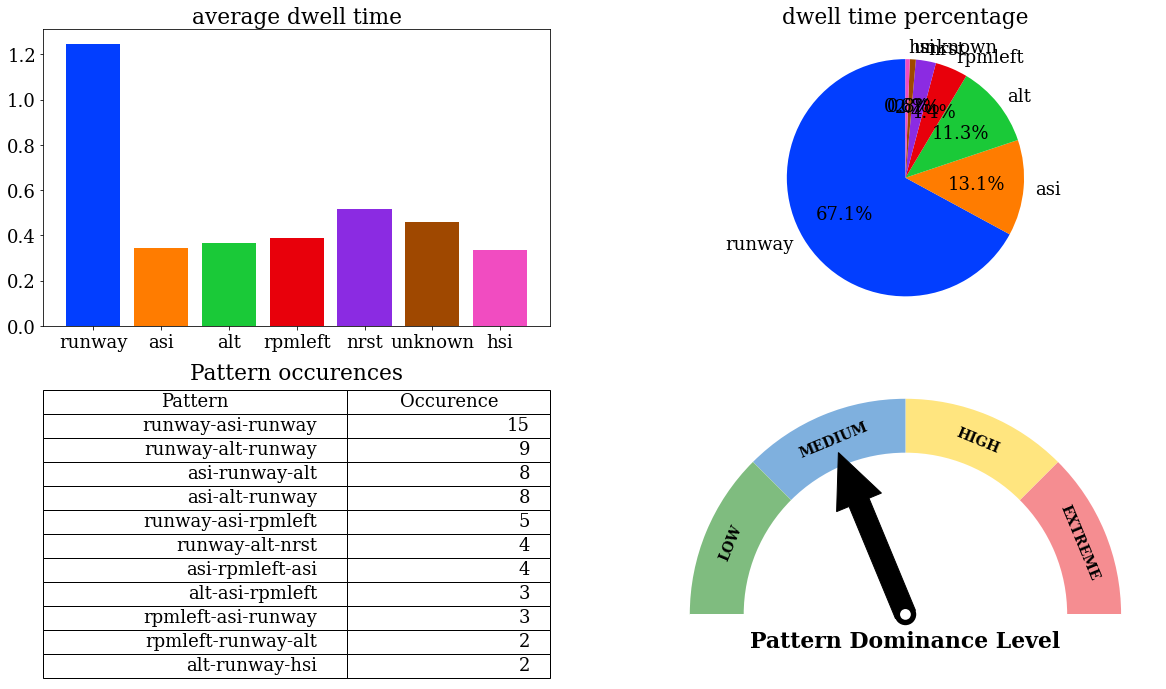

In [26]:
import matplotlib
import seaborn as sns

font = {'family' : 'serif',
        'size'   : 18}
matplotlib.rc('font', **font)
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20,12))
colors = sns.color_palette('bright')

#-----------------BAR GRAPH: average dwell time
bar_x = np.arange(len(bar_label))  # the label locations
width = 0.5

axs[0,0].bar(bar_x, bar_data, color = colors)
axs[0,0].set_xticks(bar_x)
axs[0,0].set_xticklabels(sorted_label)
axs[0,0].set_title("average dwell time")

#-----------------PIE CHART: dwell time percentage----------------
axs[0,1].pie(pie_data, explode=explode, labels=sorted_label, colors = colors, autopct='%1.1f%%',
        shadow=False, startangle=90)
axs[0,1].set_title("dwell time percentage")

#-----------------BAR GRAPH: count pattern------------------------
table = axs[1,0].table(cellText=df_pattern.values, colWidths = [0.3, 0.2], colLabels=df_pattern.columns, loc='center')
table.scale(2, 2)
axs[1,0].axis('off')
axs[1,0].axis('tight')
axs[1,0].set_title("Pattern occurences")

#-----------------Dominance pattern-------------------------------
gauge(axs[1,1], labels=['LOW','MEDIUM','HIGH','EXTREME'], \
      colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], arrow=2, title='Pattern Dominance Level')


In [25]:
from matplotlib.patches import Circle, Wedge, Rectangle
import os, sys
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np

In [22]:
def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

In [23]:
def gauge(ax, labels=['LOW','MEDIUM','HIGH','VERY HIGH','EXTREME'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
#     fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
#     plt.tight_layout()
#     if fname:
#         fig.savefig(fname, dpi=200)
        
    return ax

In [19]:
gauge(labels=['LOW','MEDIUM','HIGH','EXTREME'], \
      colors=['#007A00','#0063BF','#FFCC00','#ED1C24'], arrow=3, title='Pattern Dominance Level') 

TypeError: gauge() missing 1 required positional argument: 'ax'

# flight path

In [27]:
actual_path = np.array([2000]*10 + list(range(2000,0,-50)))
actual_path = actual_path + np.random.randint(-100, 100, size=actual_path.shape)
ideal_path = [2000]*10 + list(range(2000,0,-50))

aerror = np.abs(actual_path - ideal_path)

Text(0.5, 1.0, 'Landing path analysis')

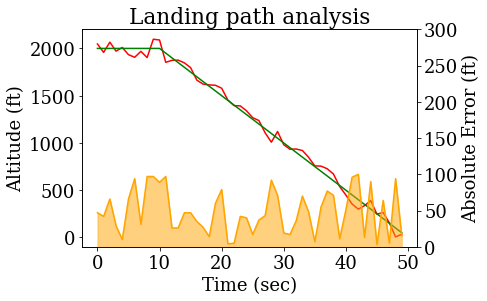

In [28]:
fig, ax1 = plt.subplots()
ax1.plot(actual_path, c = "r")
ax1.plot(ideal_path, c = "g")
ax1.set_ylabel(r'Altitude (ft)')
ax1.set_xlabel(r'Time (sec)')


ax2 = ax1.twinx()
ax2.plot(aerror, c = "orange")
xs = np.arange(len(actual_path))
ax2.fill_between(xs,aerror, 0, interpolate=True, color='orange', alpha=0.5)
ax2.set_ylim([0, 300])
ax2.set_ylabel(r'Absolute Error (ft)')
plt.title("Landing path analysis")
